In [355]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

In [356]:
experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'
experiment_type = 'reward-network-iii-8A-v1'
experiment_type = 'sim_v1'
moves_df = pd.read_csv(os.path.join('./data/pilots/',experiment_type,'moves.csv'))

<Axes: xlabel='trial_idx', ylabel='session_name'>

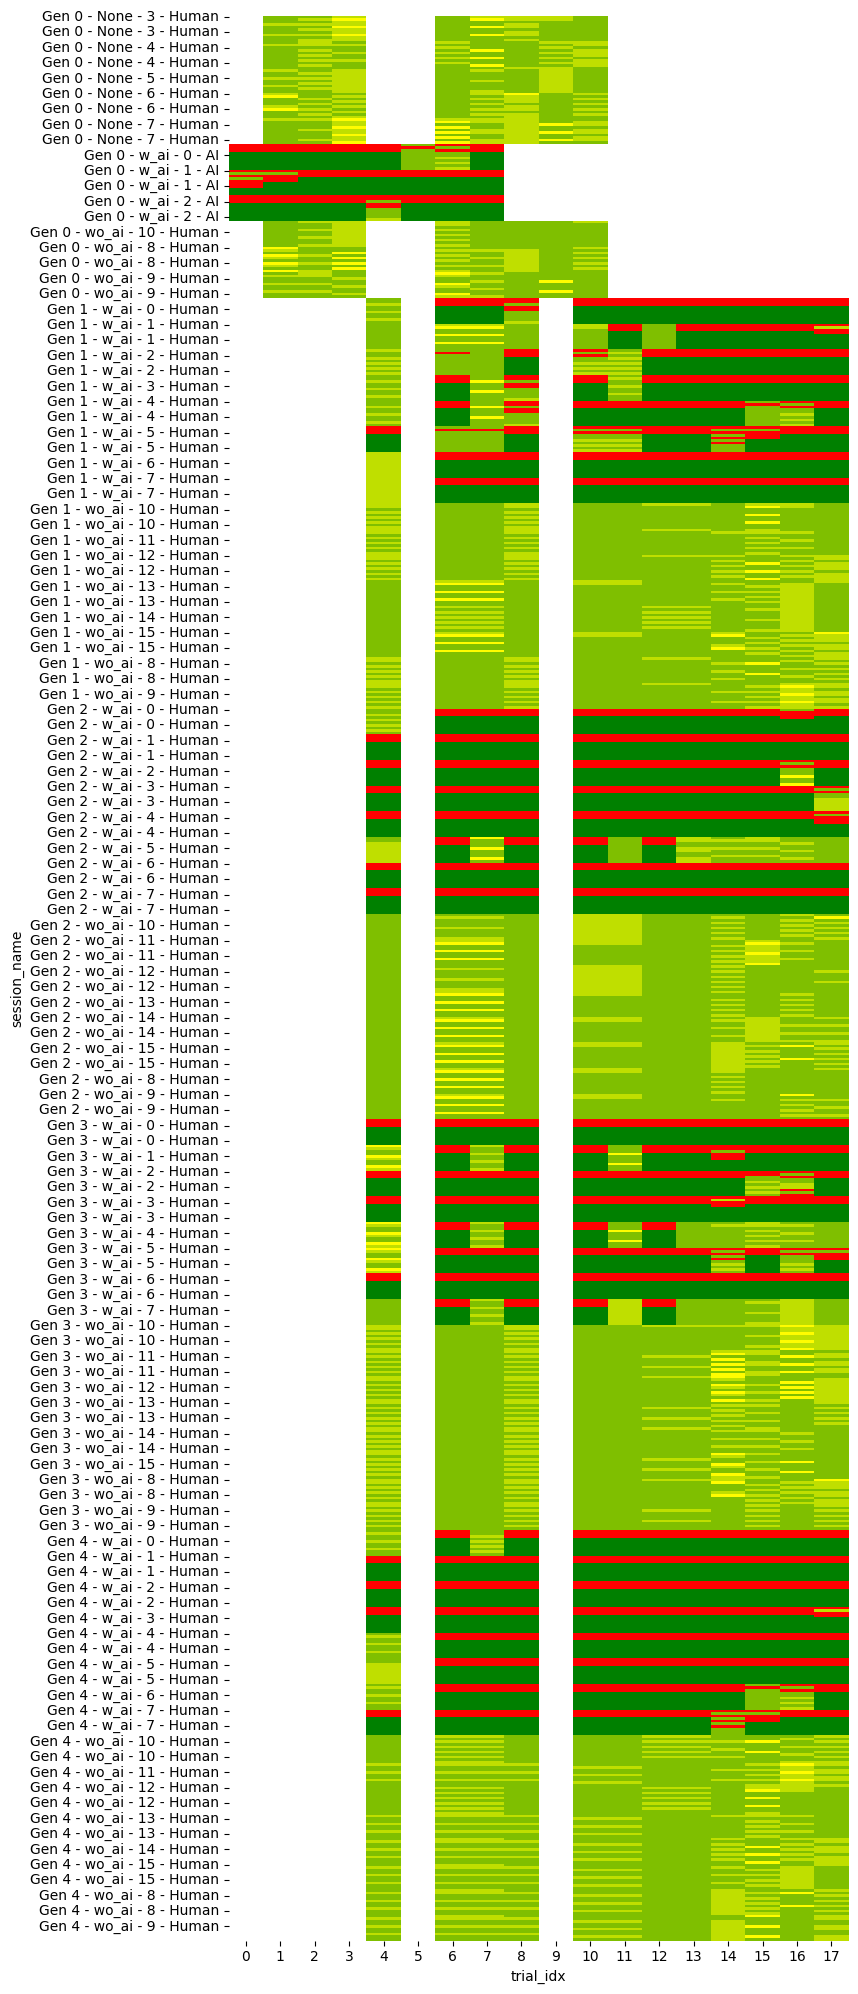

In [357]:
moves_matrix = moves_df.pivot_table(index=['player_score', 'session_name', 'move_idx'], columns=['trial_idx'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# drop all index but session_name
moves_matrix = moves_matrix.sort_index(level=[1,2], ascending=True)
moves_matrix = moves_matrix.reset_index(level=[0,2], drop=True)


# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False, vmin=-50, vmax=400)


<Axes: xlabel='trial_idx', ylabel='session_name'>

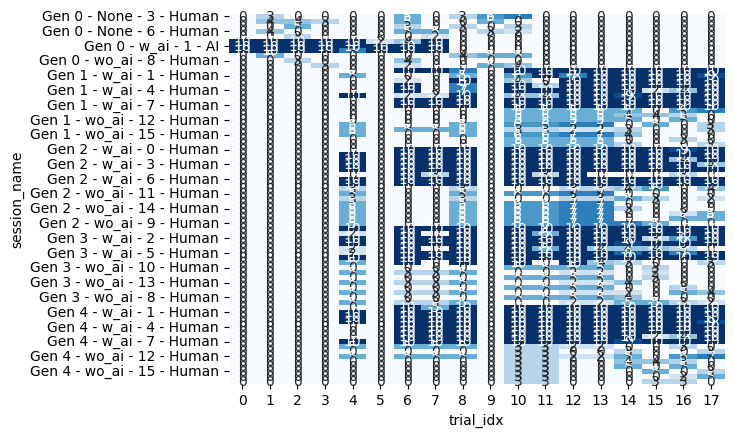

In [358]:
moves_matrix = moves_df.pivot_table(index=['session_name'], columns=['trial_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_name'>

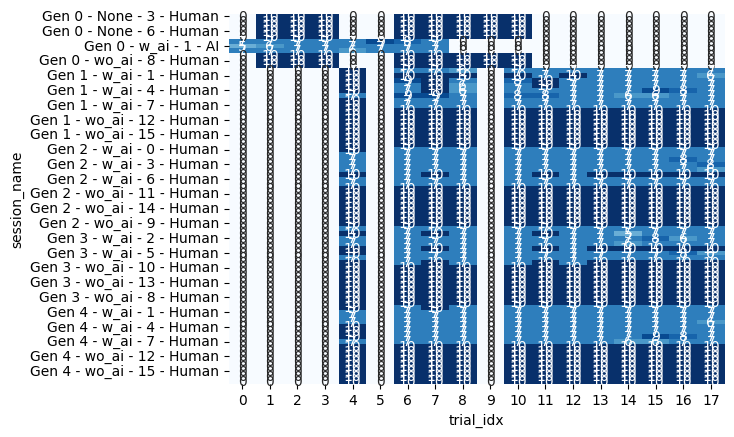

In [359]:
moves_matrix = moves_df.pivot_table(index=['session_name'], columns=['trial_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_name'>

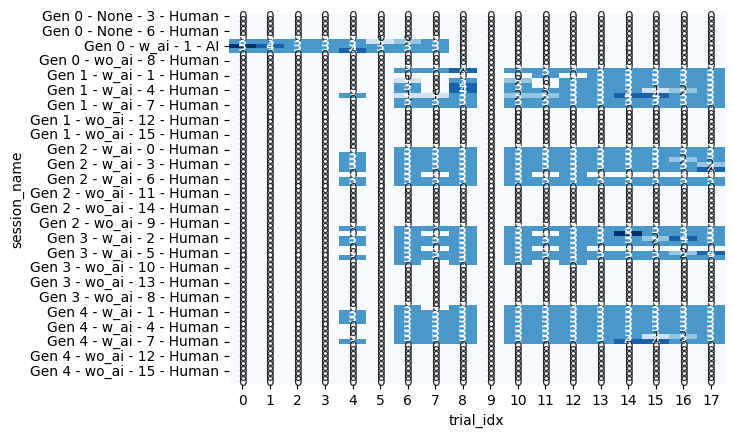

In [360]:
moves_matrix = moves_df.pivot_table(index=['session_name'], columns=['trial_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


In [361]:
# large_loss_taken, myopic, optimal

moves_behavior = moves_df.melt(id_vars=['session_id', 'condition', 'trial_idx', 'generation'], value_vars=['myopic', 'optimal'], var_name='behavior', value_name='count')


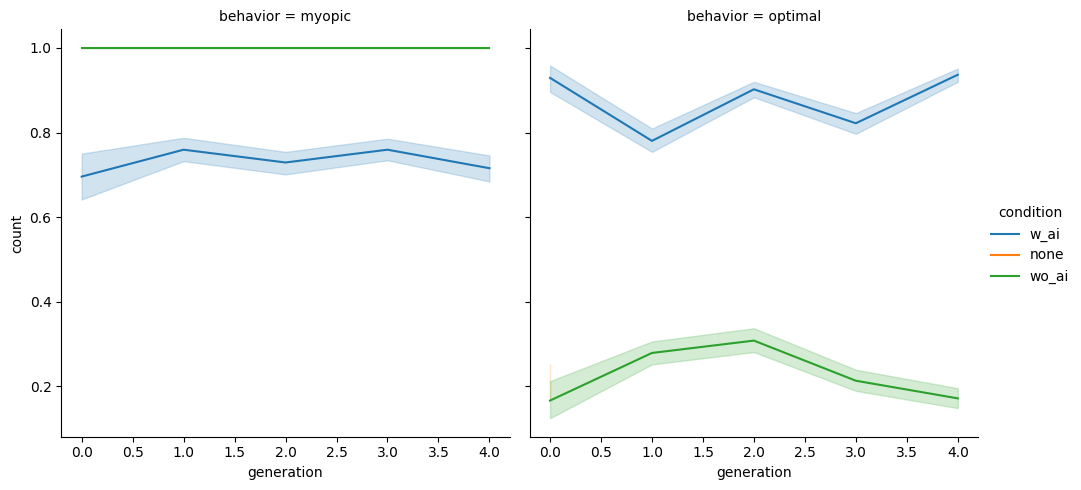

In [362]:
moves_behavior['condition'] = moves_behavior['condition'].fillna('none')

sns.relplot(data=moves_behavior, x='generation', y='count', col='behavior', hue='condition', kind='line')


<Axes: xlabel='trial_idx', ylabel='reward'>

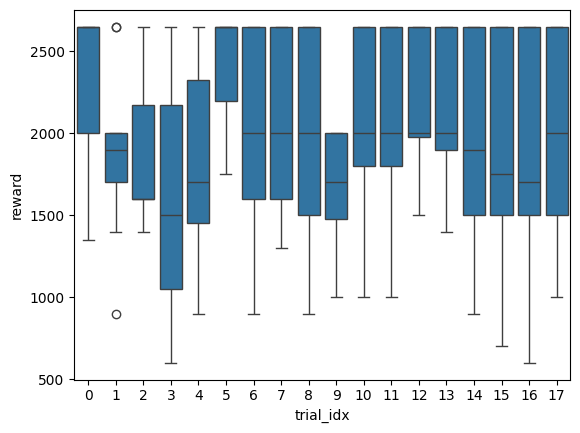

In [363]:
df_group = moves_df.groupby(['session_id', 'trial_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trial_idx', y='reward')


<Axes: xlabel='generation,condition'>

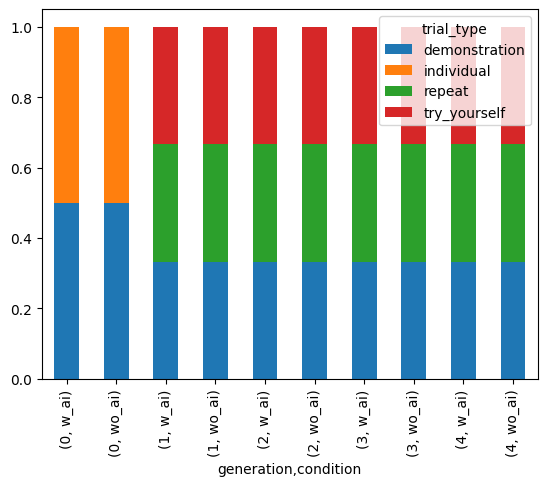

In [364]:
moves_df.groupby(['generation', 'condition'])['trial_type'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)